# Linear Classifiers

## Install starter code
We will continue using the utility functions that we've used for Assignment 1: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.

In [2]:
!pip install git+https://github.com/deepvision-class/starter-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-ngf1xkxo
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-ngf1xkxo
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10307 sha256=8b38e9e73ed86aa4d72b381d10cb0a394d35e8a3a3dee755735a072421c0320b
  Stored in directory: /tmp/pip-ephem-wheel-cache-kl2zfko2/wheels/df/48/31/42e6165d14813d97f1555dcf2a92742f78e9d0c90811ef7325
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [3]:
from __future__ import print_function
from __future__ import division

import torch
import coutils
import random
import time
import math
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Now, we will load CIFAR10 dataset, with normalization.

In this notebook we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


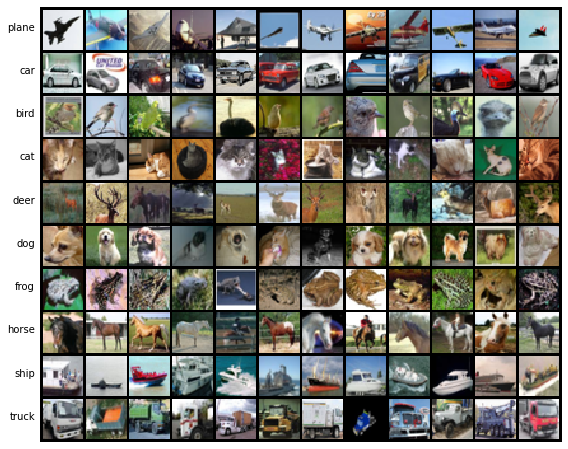

Train data shape:  torch.Size([49000, 3073])
Train labels shape:  torch.Size([49000])
Validation data shape:  torch.Size([1000, 3073])
Validation labels shape:  torch.Size([1000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


In [4]:
def get_CIFAR10_data(validation_ratio = 0.02):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Move all the data to the GPU
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Add bias dimension and transform into columns
  ones_train = torch.ones(X_train.shape[0], 1, device=X_train.device)
  X_train = torch.cat([X_train, ones_train], dim=1)
  ones_test = torch.ones(X_test.shape[0], 1, device=X_test.device)
  X_test = torch.cat([X_test, ones_test], dim=1)

  # 4. Carve out part of the training set to use for validation.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # Return the dataset as a dictionary
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

# Invoke the above function to get our data.
data_dict = get_CIFAR10_data()
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

For Softmax and SVM, we will analytically compute the gradient, as a sanity check.

In [5]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-7):
  """
  Utility function to perform numeric gradient checking. We use the centered
  difference formula to compute a numeric derivative:
  
  f'(x) =~ (f(x + h) - f(x - h)) / (2h)

  Rather than computing a full numeric gradient, we sparsely sample a few
  dimensions along which to compute numeric derivatives.

  Inputs:
  - f: A function that inputs a torch tensor and returns a torch scalar
  - x: A torch tensor giving the point at which to evaluate the numeric gradient
  - analytic_grad: A torch tensor giving the analytic gradient of f at x
  - num_checks: The number of dimensions along which to check
  - h: Step size for computing numeric derivatives
  """
  # fix random seed for 
  coutils.utils.fix_random_seed()

  for i in range(num_checks):
    
    ix = tuple([random.randrange(m) for m in x.shape])
    
    oldval = x[ix].item()
    x[ix] = oldval + h # increment by h
    fxph = f(x).item() # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x).item() # evaluate f(x - h)
    x[ix] = oldval     # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error_top = abs(grad_numerical - grad_analytic)
    rel_error_bot = (abs(grad_numerical) + abs(grad_analytic) + 1e-12)
    rel_error = rel_error_top / rel_error_bot
    msg = 'numerical: %f analytic: %f, relative error: %e'
    print(msg % (grad_numerical, grad_analytic, rel_error))

## SVM Classifier

In this section, we will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check the implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [6]:
def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as torch scalar
  - gradient of loss with respect to weights W; a tensor of same shape as W
  """
  dW = torch.zeros_like(W) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = W.t().mv(X[i])
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin
        dW[:,y[i]]+=-X[i,:].t()
        dW[:,j]+=X[i,:].t()
        

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train

  # Add regularization to the loss.
  loss += reg * torch.sum(W * W)

  dW=dW/num_train+reg*2*W

  return loss, dW

Evaluate the naive implementation of the loss provided.

In [7]:
# generate a random SVM weight tensor of small numbers
coutils.utils.fix_random_seed()
W = torch.randn(3073, 10, device=data_dict['X_val'].device) * 0.0001 

loss, grad = svm_loss_naive(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

loss: 9.000433


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`.

To check that we have implemented the gradient correctly, we can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that we computed.

In [8]:
# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=0.0) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with the analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

numerical: -0.034577 analytic: -0.034577, relative error: 2.372452e-07
numerical: 0.126951 analytic: 0.126951, relative error: 5.721190e-08
numerical: -0.068597 analytic: -0.068597, relative error: 2.249695e-07
numerical: 0.025717 analytic: 0.025717, relative error: 4.774223e-07
numerical: 0.048266 analytic: 0.048266, relative error: 2.668362e-07
numerical: 0.052260 analytic: 0.052260, relative error: 2.475153e-07
numerical: 0.096133 analytic: 0.096133, relative error: 4.690208e-09
numerical: 0.032702 analytic: 0.032702, relative error: 3.644517e-07
numerical: -0.117158 analytic: -0.117158, relative error: 4.006759e-08
numerical: -0.154093 analytic: -0.154093, relative error: 7.809949e-08


Let's do the gradient check once again with regularization turned on.

In [9]:
# Use a minibatch of data from the val set for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=1e3) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with the analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

numerical: -0.121624 analytic: -0.121624, relative error: 7.160875e-08
numerical: 0.020923 analytic: 0.020923, relative error: 3.331613e-07
numerical: -0.076604 analytic: -0.076604, relative error: 1.800879e-07
numerical: 0.256069 analytic: 0.256069, relative error: 6.121908e-08
numerical: -0.330089 analytic: -0.330089, relative error: 4.165267e-08
numerical: 0.004713 analytic: 0.004713, relative error: 3.512375e-06
numerical: 0.101968 analytic: 0.101968, relative error: 1.802643e-08
numerical: 0.097235 analytic: 0.097235, relative error: 1.618033e-07
numerical: -0.117112 analytic: -0.117112, relative error: 2.948518e-08
numerical: -0.257260 analytic: -0.257260, relative error: 4.474401e-08


Now, let's implement vectorized version of SVM: `svm_loss_vectorized`. It should compute the same inputs and outputs as the naive version before, but it should involve **no explicit loops**.

In [10]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = torch.zeros_like(W) # initialize the gradient as zero

  scores = X.mm(W)
  num_train=X[0]

  correct_label_score_idxes = (range(scores.shape[0]), y)

  correct_label_scores = scores[correct_label_score_idxes]
  scores_diff = scores - torch.reshape(correct_label_scores, (-1, 1))

  scores_diff += 1
  
  scores_diff[correct_label_score_idxes] = 0
  indexes_of_neg_nums = torch.nonzero(scores_diff < 0)
  scores_diff[indexes_of_neg_nums] = 0
  
  loss = scores_diff.sum()
  num_train = X.shape[0]
  loss /= num_train
  # add in the regularization part.
  loss += reg * (W * W).sum()

  scores_diff[scores_diff > 0] = 1
  correct_label_vals = torch.sum(scores_diff , 1) * -1
  scores_diff[correct_label_score_idxes] = correct_label_vals

  dW = X.t().mm(scores_diff)
  dW /= num_train
  # add the regularization contribution to the gradient
  dW += reg * 2* W

  return loss, dW

Let's first check the speed and performance bewteen the non-vectorized and the vectorized version.

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.

# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))

# The losses should match but the vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss: 9.000144e+00 computed in 245.68ms
Vectorized loss: 9.000144e+00 computed in 26.65ms
Difference: -1.07e-14
Speedup: 9.22X


Then, let's compute the gradient of the loss function. We can check the difference of gradient as well.

In [12]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# we use the Frobenius norm to compare them.
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.2e' % grad_difference)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss and gradient: computed in 248.53ms
Vectorized loss and gradient: computed in 2.87ms
Gradient difference: 0.00e+00
Speedup: 86.62X


Now that we have an efficient vectorized implementation of the SVM loss and its gradient, we can implement a training pipeline for linear classifiers.

Complete the implementation of the following function:


In [13]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, 
                            reg=1e-5, num_iters=100, batch_size=200, verbose=False):
  """
  Train this linear classifier using stochastic gradient descent.

  Inputs:
  - loss_func: loss function to use when training. It should take W, X, y
    and reg as input, and output a tuple of (loss, dW)
  - W: A PyTorch tensor of shape (D, C) giving the initial weights of the
    classifier. If W is None then it will be initialized here.
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c
    means that X[i] has label 0 <= c < C for C classes.
  - learning_rate: (float) learning rate for optimization.
  - reg: (float) regularization strength.
  - num_iters: (integer) number of steps to take when optimizing
  - batch_size: (integer) number of training examples to use at each step.
  - verbose: (boolean) If true, print progress during optimization.

  Returns: A tuple of:
  - W: The final value of the weight matrix and the end of optimization
  - loss_history: A list of Python scalars giving the values of the loss at each
    training iteration.
  """
  # assume y takes values 0...K-1 where K is number of classes
  num_classes = torch.max(y) + 1
  num_train, dim = X.shape
  if W is None:
    # lazily initialize W
    W = 0.000001 * torch.randn(dim, num_classes, device=X.device, dtype=X.dtype)

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for it in range(num_iters):
    X_batch = None
    y_batch = None

    batch_idxes = torch.randint(num_train, (batch_size,))
    X_batch = X[batch_idxes, :]
    y_batch = y[batch_idxes]

    # evaluate loss and gradient
    loss, grad = loss_func(W, X_batch, y_batch, reg)
    loss_history.append(loss.item())

    # perform parameter update
    W -= learning_rate * grad

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss))

  return W, loss_history

Run the following cell to train a linear classifier using some default hyperparameters:

In [14]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed()

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(svm_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=3e-11, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 9.000759
iteration 100 / 1500: loss 9.000790
iteration 200 / 1500: loss 9.000771
iteration 300 / 1500: loss 9.000764
iteration 400 / 1500: loss 9.000766
iteration 500 / 1500: loss 9.000767
iteration 600 / 1500: loss 9.000770
iteration 700 / 1500: loss 9.000748
iteration 800 / 1500: loss 9.000766
iteration 900 / 1500: loss 9.000761
iteration 1000 / 1500: loss 9.000764
iteration 1100 / 1500: loss 9.000766
iteration 1200 / 1500: loss 9.000779
iteration 1300 / 1500: loss 9.000757
iteration 1400 / 1500: loss 9.000749
That took 1.328748s


A useful debugging strategy is to plot the loss as a function of iteration number. In this case it seems our hyperparameters are not good, since the training loss is not decreasing very fast.



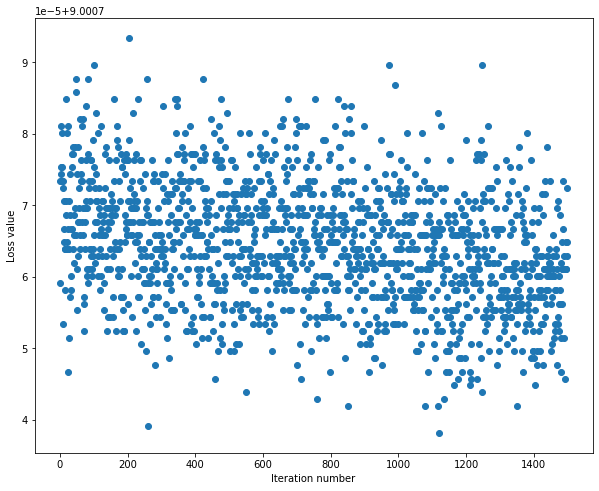

In [15]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's move on to the prediction stage:

In [16]:
def predict_linear_classifier(W, X):
  """
  Use the trained weights of this linear classifier to predict labels for
  data points.

  Inputs:
  - W: A PyTorch tensor of shape (D, C), containing weights of a model
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.

  Returns:
  - y_pred: PyTorch int64 tensor of shape (N,) giving predicted labels for each
    elemment of X. Each element of y_pred should be between 0 and C - 1.
  """
  y_pred = torch.zeros(X.shape[0])
  class_preds = X.mm(W)
  y_pred = torch.argmax(class_preds, dim=1)
  
  return y_pred

Then, let's evaluate the performance our trained model on both the training and validation set. The validation accuracy around 10%, which is not great.

In [17]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('Training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 10.24%
Validation accuracy: 10.20%


Unfortunately, the performance of the initial model is quite bad. To find a better hyperparamters, let's first modulize the functions that we've implemented.

In [1]:
# Note: We will re-use `LinearClassifier` in Softmax section
class LinearClassifier(object):
  
  def __init__(self):
    self.W = None
    
  def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg,
                  num_iters, batch_size, verbose)
    self.W, loss_history = train_linear_classifier(*train_args)
    return loss_history

  def predict(self, X):
    return predict_linear_classifier(self.W, X) 
  
  def loss(self, W, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
    - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an tensor of the same shape as W
    """
    pass
  def _loss(self, X_batch, y_batch, reg):
    self.loss(self.W, X_batch, y_batch, reg)


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, W, X_batch, y_batch, reg):
    return svm_loss_vectorized(W, X_batch, y_batch, reg)

Now, we will use the validation set to tune hyperparameters (regularization strength and learning rate).

In [18]:
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4] # learning rate candidates, e.g. [1e-3, 1e-2, ...]
regularization_strengths = [1e-1, 1e-2, 1e-3] # regularization strengths candidates e.g. [1e0, 1e1, ...]

grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths ]
X_train=data_dict['X_train'].double()
y_train=data_dict['y_train']
X_val=data_dict['X_val'].double()
y_val=data_dict['y_val']
for lr, rg in grid_search:
    # Create a new SVM instance
    svm = LinearSVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train, y_train, learning_rate=lr, reg=rg,
                      num_iters=2000,batch_size=200, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train)
    # Calculate accuracy
    train_accuracy = torch.mean((y_train_pred == y_train).float())
    # Predict values for validation set
    y_val_pred = svm.predict(X_val)
    # Calculate accuracy
    val_accuracy = torch.mean((y_val_pred == y_val).float())
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm
    
# Print out results.
for lr, reg in sorted(results):
  train_accuracy, val_accuracy = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-04 reg 1.000000e-03 train accuracy: 0.326000 val accuracy: 0.332000
lr 1.000000e-04 reg 1.000000e-02 train accuracy: 0.325224 val accuracy: 0.330000
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 0.324735 val accuracy: 0.327000
lr 1.000000e-03 reg 1.000000e-03 train accuracy: 0.334673 val accuracy: 0.349000
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 0.336000 val accuracy: 0.337000
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 0.339143 val accuracy: 0.347000
lr 1.000000e-02 reg 1.000000e-03 train accuracy: 0.336061 val accuracy: 0.348000
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 0.339490 val accuracy: 0.337000
lr 1.000000e-02 reg 1.000000e-01 train accuracy: 0.325286 val accuracy: 0.343000
lr 1.000000e-01 reg 1.000000e-03 train accuracy: 0.298531 val accuracy: 0.304000
lr 1.000000e-01 reg 1.000000e-02 train accuracy: 0.279837 val accuracy: 0.297000
lr 1.000000e-01 reg 1.000000e-01 train accuracy: 0.280837 val accuracy: 0.293000
best validation accuracy ach

Visualize the cross-validation results.

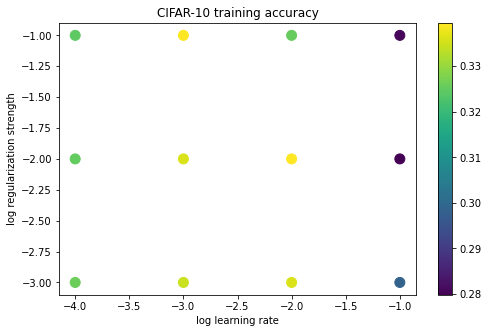

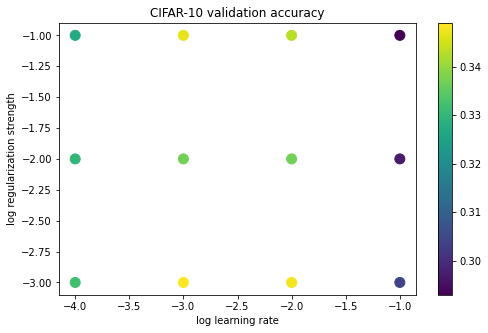

In [33]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [torch.Tensor.cpu(results[x][0]) for x in results]

plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [torch.Tensor.cpu(results[x][1]) for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Evaluate the best svm on test set.



In [ ]:
y_test_pred = best_svm.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

Visualize the learned weights for each class.

In [ ]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])

## Softmax Classifier

Similar to the SVM, we will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check our implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

First, let's start from implementing the naive softmax loss function with nested loops.


In [ ]:
def delta(a,b):
  return 1 if a == b else 0

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an tensor of same shape as W
  """
  # Initialize the loss and gradient to zero.
  D, C = W.shape; N = X.shape[0]
  loss = 0.0
  dW = torch.zeros_like(W)

  # Calculates the cross-entropy loss on the softmax function
  result = X @ W  # N x C
  max_values = torch.max(result, 1).values.view((N,1))
  result = result - max_values  # Translate results to avoid large numbers

  predict = torch.exp(result)
  sums = predict.sum(dim=1)
  loss_vec = -torch.log(predict[list(range(N)),y]) + torch.log(sums)
  loss = loss_vec.sum() / N

  # Add reg
  loss += torch.sum(W ** 2)

  # sum_c[:,c] is the derivative of L w.r.t. W_c
  sum_c = torch.zeros((D,C), device=X.device)

  for c in range(C):
    for i in range(N):
      sum_c[:,c] += (delta(c,y[i]) - torch.exp(torch.dot(W[:,c], X[i])) / sums[i]) * X[i]

  dW = sum_c / (-N)

  # Add reg
  dW += 2 * reg * W

  return loss, dW

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization.

In [ ]:
# Generate a random softmax weight tensor and use it to compute the loss.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.302906
sanity check: 2.302585


Next, we use gradient checking to debug the analytic gradient of our naive softmax loss function.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.008300 analytic: 0.008387, relative error: 5.195094e-03
numerical: 0.009121 analytic: 0.009220, relative error: 5.379986e-03
numerical: -0.002479 analytic: -0.002458, relative error: 4.225678e-03
numerical: -0.002914 analytic: -0.003151, relative error: 3.910425e-02
numerical: 0.005633 analytic: 0.006013, relative error: 3.265489e-02
numerical: 0.005888 analytic: 0.005941, relative error: 4.492447e-03
numerical: 0.015709 analytic: 0.015722, relative error: 4.162458e-04
numerical: 0.006517 analytic: 0.006451, relative error: 5.021241e-03
numerical: -0.015533 analytic: -0.015538, relative error: 1.522703e-04
numerical: -0.010273 analytic: -0.010157, relative error: 5.659237e-03


Let's perform another gradient check with regularization enabled.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
reg = 10.0

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.008300 analytic: 0.007516, relative error: 4.955563e-02
numerical: 0.009121 analytic: 0.008160, relative error: 5.564562e-02
numerical: -0.002479 analytic: -0.002538, relative error: 1.180184e-02
numerical: -0.002914 analytic: -0.000847, relative error: 5.494104e-01
numerical: 0.005633 analytic: 0.002229, relative error: 4.328635e-01
numerical: 0.005888 analytic: 0.005466, relative error: 3.719620e-02
numerical: 0.015709 analytic: 0.015781, relative error: 2.268429e-03
numerical: 0.006517 analytic: 0.007097, relative error: 4.262103e-02
numerical: -0.015533 analytic: -0.015537, relative error: 1.372851e-04
numerical: -0.010273 analytic: -0.011189, relative error: 4.268252e-02


Then, let's move on to the vectorized form

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  D, C = W.shape; N = X.shape[0]
  loss = 0.0
  dW = torch.zeros_like(W)
  
  # Calculates the cross-entropy loss on the softmax function
  result = X @ W  # N x C
  max_values = torch.max(result, 1).values.view((N,1))
  result = result - max_values  # Translate results to avoid large numbers

  predict = torch.exp(X @ W)
  sums = predict.sum(dim=1)
  loss_vec = -torch.log(predict[list(range(N)),y]) + torch.log(sums)
  loss = loss_vec.sum() / N

  # Add reg
  loss += torch.sum(W ** 2)

  # One-hot encoding of class
  D = torch.zeros((N,C), device='cuda')
  D[list(range(N)), y] = 1

  # Softmax result
  S = predict / sums.view((N,1))

  dW = (-1/N) * (X.T @ (D - S)) + 2 * reg * W

  return loss, dW

Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 2.302906e+00 computed in 179.135323s
vectorized loss: 2.302906e+00 computed in 2.152443s
Loss difference: 0.00e+00
Gradient difference: 1.24e-03
Speedup: 83.22X


Let's check that our implementation of the softmax loss is numerically stable.

In [ ]:
device = data_dict['X_train'].device
dtype = torch.float32
D = data_dict['X_train'].shape[1]
C = 10

W_ones = torch.ones(D, C, device=device, dtype=dtype)
print(W_ones.shape)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


torch.Size([3073, 10])
iteration 0 / 1: loss 30732.302734
iteration 0 / 1: loss 30732.302734


Now lets train a softmax classifier with some default hyperparameters:


In [ ]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed(10)

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.302587
iteration 100 / 1500: loss 2.302586
iteration 200 / 1500: loss 2.302587
iteration 300 / 1500: loss 2.302585
iteration 400 / 1500: loss 2.302586
iteration 500 / 1500: loss 2.302586
iteration 600 / 1500: loss 2.302588
iteration 700 / 1500: loss 2.302587
iteration 800 / 1500: loss 2.302585
iteration 900 / 1500: loss 2.302587
iteration 1000 / 1500: loss 2.302587
iteration 1100 / 1500: loss 2.302586
iteration 1200 / 1500: loss 2.302585
iteration 1300 / 1500: loss 2.302587
iteration 1400 / 1500: loss 2.302585
That took 1.268131s


Plot the loss curve:

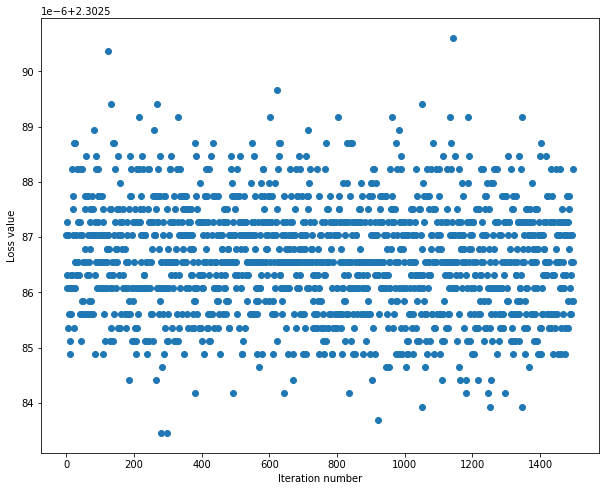

In [ ]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's compute the accuracy of current model. It is less than 10% which isn't good.

In [ ]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.43%
validation accuracy: 8.00%


Now use the validation set to tune hyperparameters (regularization strength and learning rate).

In [ ]:
class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """
  def loss(self, W, X_batch, y_batch, reg):
    return softmax_loss_vectorized(W, X_batch, y_batch, reg)

In [ ]:
results = {}
best_val = -1
best_hparams = None
best_W = None
best_softmax = None

learning_rates = [1e-8, 1e-6, 1e-4, 1e-3, 1e-2] # learning rate candidates
regularization_strengths = [2.5e2, 2.5, 0.25, 0.025] # regularization strengths candidates

# As before, store the cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_accuracy, val_accuracy)
results = {}

for lr in learning_rates:
  for reg in regularization_strengths:
    W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=lr, reg=reg,
                                       num_iters=1500, verbose=False)
    
    # evaluate the performance on both the training and validation set
    y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
    train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()

    y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
    val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()

    if val_acc > best_val:
      best_val = val_acc
      best_hparams = (lr, reg)
      best_W = W

    results[(lr,reg)] = (train_acc, val_acc)
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print(f'best learning rate and regularisation strength is: {best_hparams}')
best_softmax = Softmax(); best_softmax.W = best_W

lr 1.000000e-08 reg 2.500000e-02 train accuracy: 22.204080 val accuracy: 22.500001
lr 1.000000e-08 reg 2.500000e-01 train accuracy: 21.546938 val accuracy: 21.900001
lr 1.000000e-08 reg 2.500000e+00 train accuracy: 21.424489 val accuracy: 21.300001
lr 1.000000e-08 reg 2.500000e+02 train accuracy: 21.642856 val accuracy: 23.900001
lr 1.000000e-06 reg 2.500000e-02 train accuracy: 24.308163 val accuracy: 25.900000
lr 1.000000e-06 reg 2.500000e-01 train accuracy: 24.546938 val accuracy: 25.900000
lr 1.000000e-06 reg 2.500000e+00 train accuracy: 24.320407 val accuracy: 25.900000
lr 1.000000e-06 reg 2.500000e+02 train accuracy: 24.385713 val accuracy: 26.000002
lr 1.000000e-04 reg 2.500000e-02 train accuracy: 25.799999 val accuracy: 26.600000
lr 1.000000e-04 reg 2.500000e-01 train accuracy: 25.826529 val accuracy: 26.900002
lr 1.000000e-04 reg 2.500000e+00 train accuracy: 25.504079 val accuracy: 26.500002
lr 1.000000e-04 reg 2.500000e+02 train accuracy: 24.348979 val accuracy: 26.100001
lr 1

Run the following to visualize the cross-validation results:

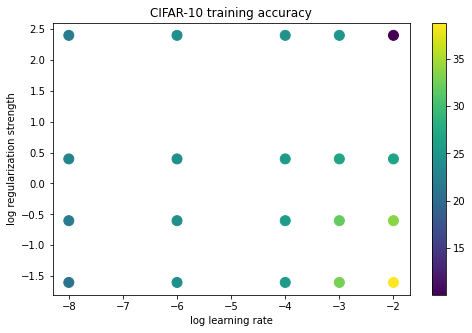

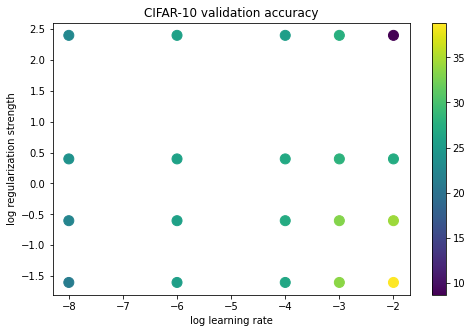

In [ ]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Them, evaluate the performance of our best model on test set.



In [ ]:
y_test_pred = best_softmax.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.382700


Finally, let's visualize the learned weights for each class. We can see that some of the classes are symmetrical, such as the weights for class "horse" that has its head pointign both left and right.

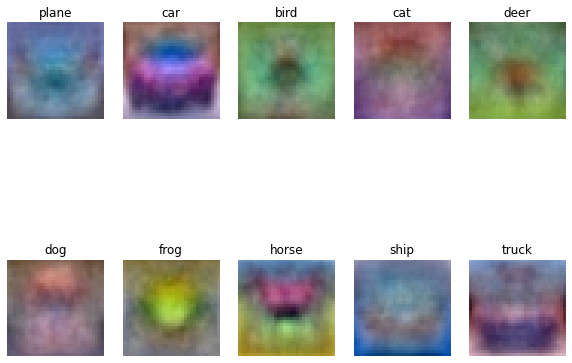

In [ ]:
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])